# 0. Importing Necessary Packages

In [1]:
%set_env PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin
# python vscode kernel restart 이후에도 base(python 3.7.6) 정상 작동하는 역할

env: PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin


In [3]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'astropy', 'pandas']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.5
matplotlib: ver 3.5.2
astropy: ver 5.1
pandas: ver 1.4.4


In [3]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
import pandas as pd
#from acstools import acszpt
#from reproject import reproject_interp

In [4]:
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'normal'})

plt.rcParams.update({'xtick.direction': 'in'})
plt.rcParams.update({'ytick.direction': 'in'})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'xtick.minor.size': 6})
plt.rcParams.update({'ytick.major.size': 10})
plt.rcParams.update({'ytick.minor.size': 6})
plt.rcParams.update({'xtick.major.width': 1.6})
plt.rcParams.update({'xtick.minor.width': 1.6})
plt.rcParams.update({'ytick.major.width': 1.6})
plt.rcParams.update({'ytick.minor.width': 1.6})

plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'axes.linewidth': 1.6})
plt.rcParams.update({'axes.labelpad': 4})
plt.rcParams.update({'xtick.major.pad': 7})
plt.rcParams.update({'image.origin':'lower'})
%config InlineBackend.figure_format = 'retina'

# 1. Writing Input Files

## 1) Image list

105 150 200 중 105 150 먼저 쓰기 / 105가 ref

In [7]:
dir_img = "../../../img/align-image/" #"../FWHM/SExtractor/img_edit/"
band = ["F115W", "F200W"]
imglist_sub = sorted(glob.glob(dir_img+"*.fits"))
imglist_sub
imglist = [imglist_sub[0], imglist_sub[4]]
imglist

['../../../img/align-image/jw01345-o002_t022_nircam_clear_f115w_aligned.fits',
 '../../../img/align-image/jw01345-o002_t022_nircam_clear_f200w_aligned.fits']

## 2) Configuration file

In [8]:
config_name = "config.txt"
os.system("sex -dd > "+config_name)

0

## 3) Output parameter file

In [9]:
param_name = "output.param"
f = open(param_name, "w")
f.write("X_IMAGE\n")    # Object position along x [pixel]
f.write("Y_IMAGE\n")    # Object position along y [pixel]
f.write("NUMBER\n")    # Object number
f.write("MAG_AUTO\n")    # Kron-like elliptical aperture magnitude [mag]
f.write("MAGERR_AUTO\n")    # RMS error for MAG_AUTO    [mag]
f.write("MAG_ISO\n") # Isophotal Magnitude
f.write("MAGERR_ISO\n") # Isophotal Magnitude Error
f.write("MAG_ISOCOR\n")
f.write("MAGERR_ISOCOR\n")
f.write("KRON_RADIUS\n")    # Kron apertures in units of A or B
f.write("BACKGROUND\n")    # Background at centroid position
f.write("ALPHA_J2000\n")    # Right ascension of object center (J2000)
f.write("DELTA_J2000\n")    # Declination of object center (J2000)
f.write("A_IMAGE\n")    # Along major axis
f.write("B_IMAGE\n")    # Along minor axis
f.write("THETA_IMAGE\n")    # Position angle
f.write("MU_MAX\n")    # Peak surface brightness above background
f.write("FLAGS\n")    # Extraction flags
f.write("FWHM_IMAGE\n")    # FWHM assuming a gaussian core
f.write("FLUX_RADIUS\n")    # Half-light radii
f.write("CLASS_STAR\n")    # Star/Galaxy classifier output
f.close()

## 4) Determining input parameters

In [10]:
hdr_1 = fits.getheader(imglist[0], ext=1)
hdr_2 = fits.getheader(imglist[1], ext=1)

reference for zp in JWST docs <br> 
https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-absolute-flux-calibration-and-zeropoints


use AB mag

### 4-a) zeropoint calculation from imageheader value

In [14]:
# band = ["F105W", "F160W"]
cat_name = ["{}.cat".format(band[0]), "{}.cat".format(band[1])]
detect_minarea = 9  # DETECT_MINAREA = 5 (default)
detect_thresh = 0.3  #1이었음 # DETECT_THRESH = 1.5 (default)
saturated = 100.0  # SATUR_LEVEL = 100.0 (depending on the image!)
mag0 = [-6.10-2.5*np.log10(hdr_1['PIXAR_SR']),
        -6.10-2.5*np.log10(hdr_2['PIXAR_SR'])]
# mag0 = [26.268, 25.946]
# egain = [hdr_1['CCDGAIN']*hdr_1['EXPTIME'], hdr_2['CCDGAIN']*hdr_2['EXPTIME']]
# GAIN (effective gain) = gain*exptime (for c/s image) --> this parameter only affects the magnitude error value!
pixel_scale = 0.03  # arcsec/pixel
fwhm = [0.08, 0.08] #이번에 내가 쓰는 reduce img는 0.06arcsec/pixel   # For HST images, seeing FWHMs are typically 3 pixels (~ 0.09 arcsec).
# However, you can directly measure the FWHM value in your image using imexamine or etc.,
# because the FWHM value can also vary with image quality.
back_size = [64, 64]  # BACK_SIZE = 64 (default) --> 32 (revised)
# Smaller BACK_SIZE --> Can subtract more local background --> Can detect more sources
back_filtersize = [3, 3]

checkimg = ["{}_aper.fits".format(band[0]), "{}_aper.fits".format(band[1])]  # CHECKIMAGE_NAME (apertures)
refimg = imglist[0]


deblend_nthresh = [64, 64]
debelnd_mincont = [0.0001, 0.0001]

backphoto_type = "LOCAL"
backphoto_thick = 24

weight_image = ["../../../img/align-image/jw01345-o002_t022_nircam_clear_f115w_aligned.fits[4]","../../../img/align-image/jw01345-o002_t022_nircam_clear_f200w_aligned.fits[2]"]
refimg_rmsmap = weight_image[0]
weight_type = "MAP_WEIGHT" #MAP_RMS, MAP_WEIGHT
weight_gain = "Y"

filtering = "Y"
filter_name = "../config/default.conv"
# filter_thresh = [0.5, 1.0]

### 4-b) PHOTFLAM / PHOTPLAM calculation by ACS zeropoint calculation system

In [15]:
''' 
dates = ['2011-07-16']
queries1 = []
queries2 = []
for date in dates:
    q1 = acszpt.Query(date=date, detector='WFC', filt='F606W')
    zpt_table = q1.fetch()
    # Each object has a zpt_table attribute, so we save the instance
    queries1.append(q1)
for date in dates:
    q2 = acszpt.Query(date=date, detector='WFC', filt='F814W')
    zpt_table = q2.fetch()
    # Each object has a zpt_table attribute, so we save the instance
    queries2.append(q2)


hdr_1["PHOTFLAM"]= q1.zpt_table['PHOTFLAM'][0].value
hdr_1["PHOTPLAM"]= q1.zpt_table['PHOTPLAM'][0].value
hdr_2["PHOTFLAM"]= q2.zpt_table['PHOTFLAM'][0].value
hdr_2["PHOTPLAM"]= q2.zpt_table['PHOTPLAM'][0].value


''' 

' \ndates = [\'2011-07-16\']\nqueries1 = []\nqueries2 = []\nfor date in dates:\n    q1 = acszpt.Query(date=date, detector=\'WFC\', filt=\'F606W\')\n    zpt_table = q1.fetch()\n    # Each object has a zpt_table attribute, so we save the instance\n    queries1.append(q1)\nfor date in dates:\n    q2 = acszpt.Query(date=date, detector=\'WFC\', filt=\'F814W\')\n    zpt_table = q2.fetch()\n    # Each object has a zpt_table attribute, so we save the instance\n    queries2.append(q2)\n\n\nhdr_1["PHOTFLAM"]= q1.zpt_table[\'PHOTFLAM\'][0].value\nhdr_1["PHOTPLAM"]= q1.zpt_table[\'PHOTPLAM\'][0].value\nhdr_2["PHOTFLAM"]= q2.zpt_table[\'PHOTFLAM\'][0].value\nhdr_2["PHOTPLAM"]= q2.zpt_table[\'PHOTPLAM\'][0].value\n\n\n'

## 5) Shell script for SExtractor photometry

In [16]:
scr_name = "sephot.sh"
f = open(scr_name, "w")
for i in np.arange(len(band)):
        
    # Reference image 
    if (imglist[i] == refimg):
        txt = "sex "+imglist[i]+"[1]"+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "
        txt += f"-WEIGHT_GAIN {weight_gain:s} -WEIGHT_IMAGE {weight_image[i]:s} -WEIGHT_TYPE {weight_type:s} "

    # Non-reference image
    else:
        txt = "sex "+refimg+"[1]"+","+imglist[i]+"[1]"+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "
        txt += f"-WEIGHT_GAIN {weight_gain:s} -WEIGHT_IMAGE {refimg_rmsmap:s},{weight_image[i]:s} -WEIGHT_TYPE {weight_type:s} "

    #==== new added param
    txt += f"-BACK_FILTERSIZE {back_filtersize[i]:d} -DEBLEND_NTHRESH {deblend_nthresh[i]:d} -DEBLEND_MINCONT {debelnd_mincont[i]:.5f} -BACKPHOTO_TYPE {backphoto_type:s} -BACKPHOTO_THICK {backphoto_thick:d} "
    txt += f"-FILTER {filtering:s} -FILTER_NAME {filter_name:s} " #filtering part 제대로 적용안되는 듯 하면서 여전히 -FILTER_THRESH {filter_thresh[0]:.4f},{filter_thresh[1]:.4f} "
    #==== origin param
    txt += f"-DETECT_MINAREA {detect_minarea:d} -DETECT_THRESH {detect_thresh:.1f} "
    txt += f"-SATUR_LEVEL {saturated:.1f} "#txt += f"-FILTER_NAME /usr/share/sextractor/default.conv -SATUR_LEVEL {saturated:.1f} "
    txt += f"-MAG_ZEROPOINT {mag0[i]:.4f} -PIXEL_SCALE {pixel_scale:.2f} " #-GAIN {egain[i]:.2f} "
    txt += f"-SEEING_FWHM {fwhm[i]:.2f} -STARNNW_NAME ../config/default.nnw -BACK_SIZE {back_size[i]:d} "
    txt += "-CHECKIMAGE_TYPE APERTURES -CHECKIMAGE_NAME "+checkimg[i] # -CHECKIMAGE_TYPE APERTURES 
    txt += "\n"
    
    f.write(txt)
    
    
f.close()

# 2. Running SExtractor

use alignimage for dual-mode (same frame size need)

In [17]:
os.system("sh sephot.sh")
# Run this and see the terminal where the Jupyter Notebook is open!

> 
----- SExtractor 2.25.0 started on 2023-02-15 at 11:32:42 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for jw01345-o002_t022_nircam_clear_f115w_aligned.fits
----- Measuring from: jw01345-o002_t022_nircam_clear_f115w_aligned.fits [1/9]
      "Unnamed" / no ext. header / 9929x4388 / 32 bits (floats)
> Looking for jw01345-o002_t022_nircam_clear_f115w_aligned.fits
----- Weighting from: jw01345-o002_t022_nircam_clear_f115w_aligned.fits [4/9]
      "Unnamed" / no ext. header / 9929x4388 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at

0

# 3. Reading the Data

In [18]:
# exec("dat_{} = np.genfromtxt(cat_name[0], dtype=None, encoding='ascii', names=colnames)".format(band[0]))
# exec("dat_{} = np.genfromtxt(cat_nam"e[1], dtype=None, encoding='ascii', names=colnames)".format(band[1]))
# Code that makes data name containts wave band
colnames = ['x','y','num','mag_auto','magerr_auto','mag_iso','magerr_iso','mag_isocor','magerr_isocor','kron','backgr','ra','dec', 
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']
dat_0 = np.genfromtxt(cat_name[0], dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt(cat_name[1], dtype=None, encoding='ascii', names=colnames)

In [25]:
pd.DataFrame(dat_0).head(5)

,x,y,num,mag_auto,magerr_auto,mag_iso,magerr_iso,mag_isocor,magerr_isocor,kron,...,ra,dec,a,b,theta,mu0,flag,fwhm,flxrad,cl
0,2504.1592,6.4444,1,28.4183,0.3559,28.6392,0.2275,28.5223,0.2088,3.5,...,214.848097,52.910154,2.351,0.767,2.43,23.5594,19,8.03,2.077,0.877
1,3097.7036,7.6150,2,28.4735,0.3096,29.0854,0.2176,29.0181,0.2068,3.5,...,214.853642,52.914089,1.257,0.802,17.58,23.1323,19,5.99,1.779,0.726
2,3629.5940,11.4768,3,30.1255,0.8257,29.6185,0.3220,29.4573,0.2888,3.5,...,214.858644,52.917600,1.259,0.493,3.90,23.9976,0,4.68,1.255,0.636
3,1687.1289,11.3116,4,29.5606,1.2865,29.7335,0.4835,29.5328,0.4223,3.5,...,214.840536,52.904699,2.142,0.499,2.57,23.7890,19,6.17,1.280,0.665
4,2694.6523,12.5744,5,30.4559,0.7535,30.7423,0.5646,30.4371,0.4721,3.5,...,214.849940,52.911384,1.293,0.492,2.50,24.5621,0,0.53,1.515,0.485


In [26]:
pd.DataFrame(dat_1).head(5)

,x,y,num,mag_auto,magerr_auto,mag_iso,magerr_iso,mag_isocor,magerr_isocor,kron,...,ra,dec,a,b,theta,mu0,flag,fwhm,flxrad,cl
0,2504.1592,6.4444,1,99.0000,99.0000,99.0000,99.0000,99.0000,99.0000,0.0,...,214.846908,52.910159,2.351,0.767,2.43,25.1728,19,1.17,3.184,0.393
1,3097.7036,7.6150,2,28.6917,0.0846,30.5266,0.2533,29.8079,0.2172,3.5,...,214.852454,52.914095,1.257,0.802,17.58,24.5234,19,5.99,2.706,0.728
2,3629.5940,11.4768,3,99.0000,99.0000,99.0000,99.0000,99.0000,99.0000,0.0,...,214.857456,52.917606,1.259,0.493,3.90,26.5732,0,0.00,7.555,0.347
3,1687.1289,11.3116,4,99.0000,99.0000,31.6681,0.6890,28.4724,0.0773,0.0,...,214.839348,52.904705,2.142,0.499,2.57,24.9482,19,2.02,-0.857,0.400
4,2694.6523,12.5744,5,29.7003,0.1918,31.0655,0.4111,30.5060,0.3325,3.5,...,214.848751,52.911390,1.293,0.492,2.50,24.8443,0,4.74,2.092,0.425


# 5. Plotting the Figures

In [27]:
%matplotlib inline

### 0) RA/DEC

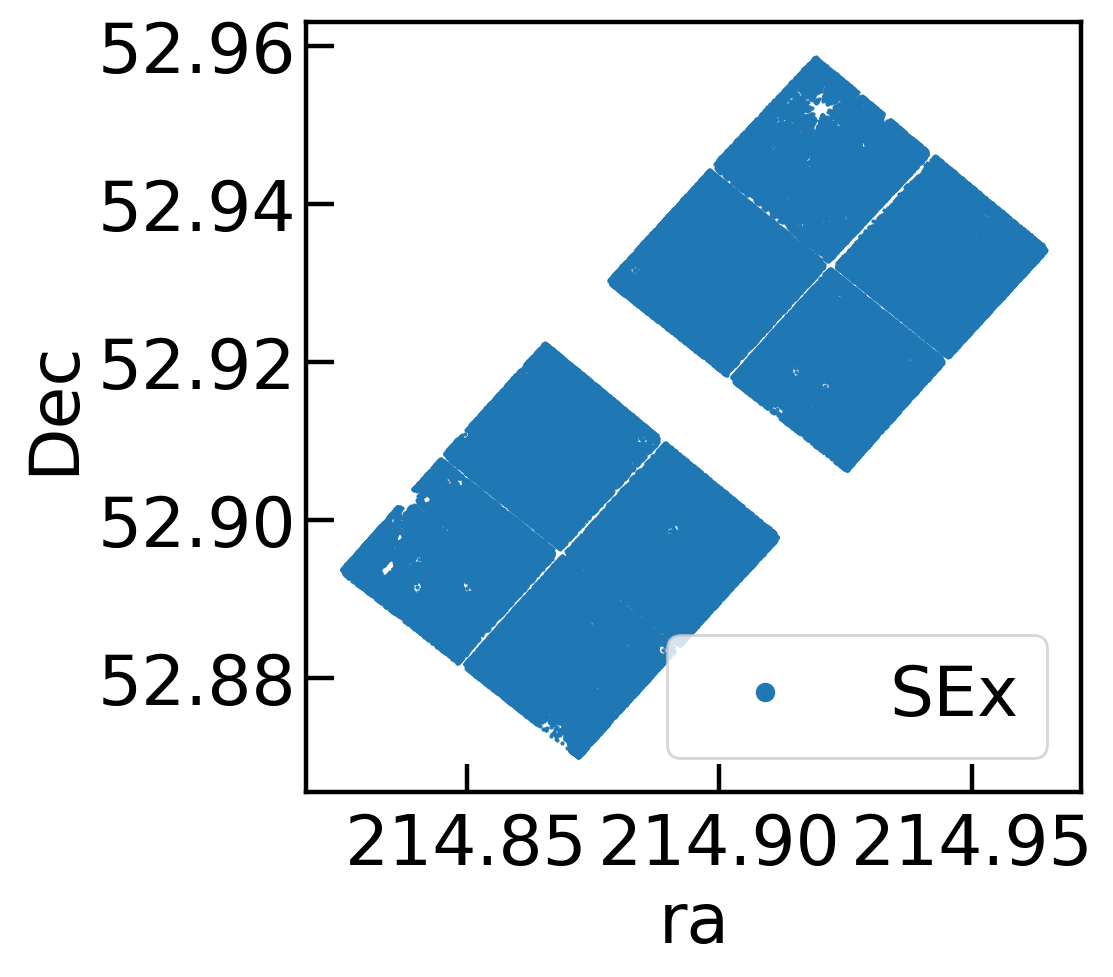

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.plot(dat_0['ra'], dat_0['dec'], 'o', ms=0.5, label = 'SEx')
axs.set_xlabel("ra")
axs.set_ylabel("Dec")
# change legend markersize
lgnd = axs.legend()
lgnd.legendHandles[0].set_markersize(6)


### 1) Mag-MagErr Plot

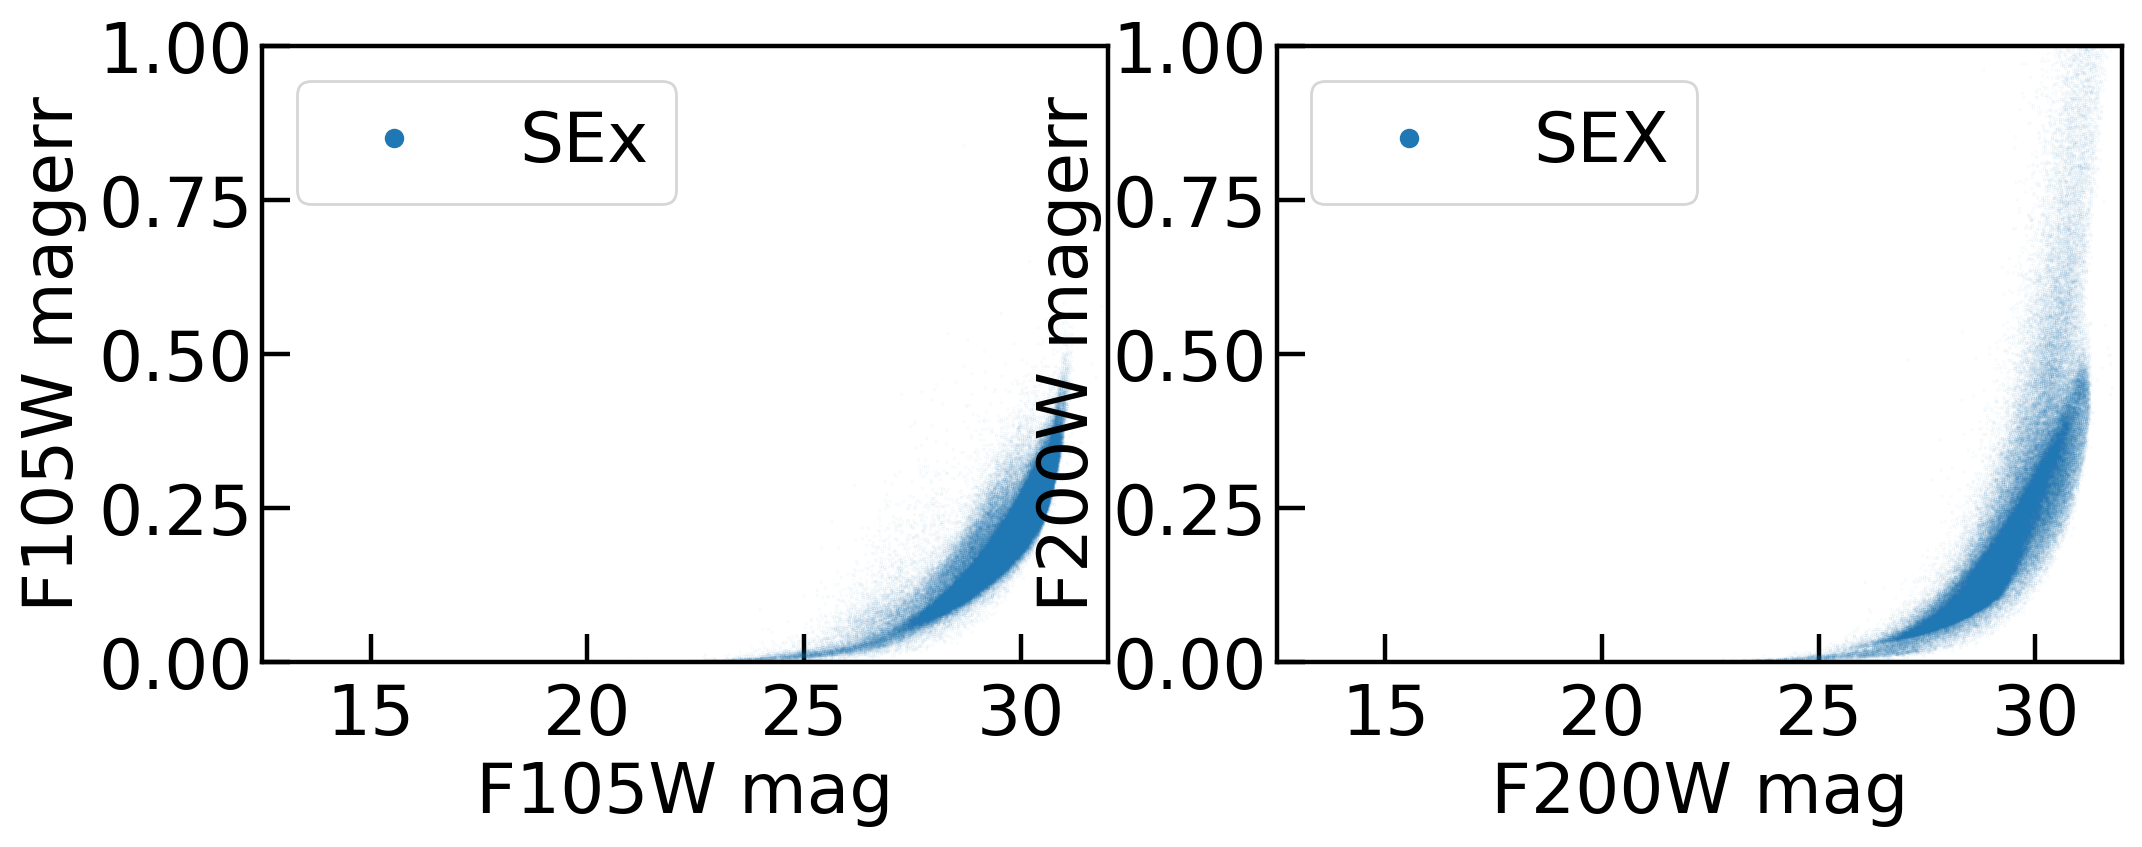

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
# mag_range = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)

# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'], dat_0['magerr_isocor'], 'o', ms=0.01, label='SEx')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('F105W mag')
ax[0].set_ylabel('F105W magerr')


ax[1].plot(dat_1['mag_isocor'], dat_1['magerr_isocor'], 'o', ms=0.01, label='SEX')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('F200W mag')
ax[1].set_ylabel('F200W magerr')

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0].set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0].set_markersize(6)

In [30]:
psle0 = np.sqrt(fits.getheader(imglist[0], ext=1)['PIXAR_A2'])
psle1 = np.sqrt(fits.getheader(imglist[1], ext=1)['PIXAR_A2'])

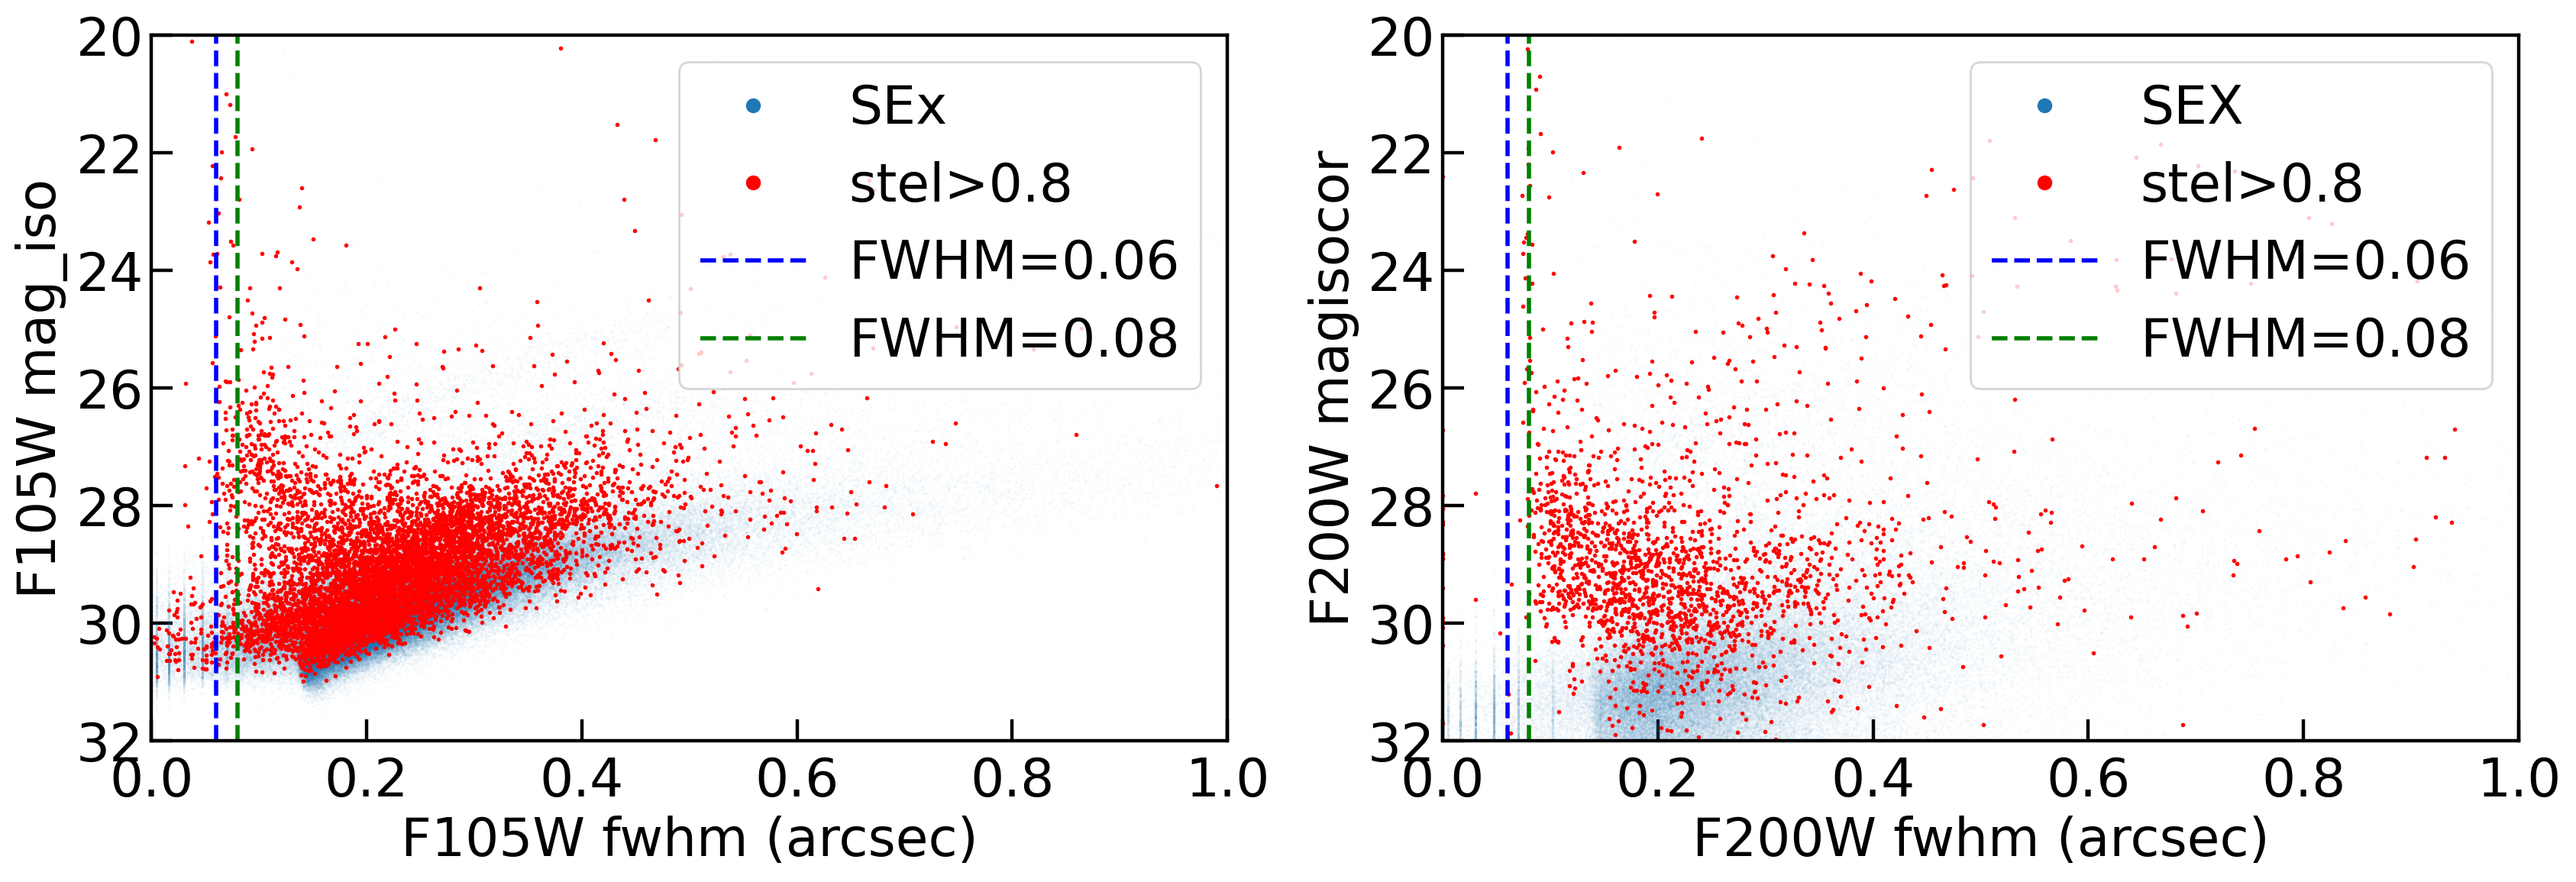

<Figure size 640x480 with 0 Axes>

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
stel0 = dat_0['cl']>0.8
stel1 = dat_1['cl']>0.8

# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['fwhm']*psle0, dat_0['mag_iso'], 'o', ms=0.01, label='SEx')
ax[0].plot(dat_0['fwhm'][stel0]*psle0, dat_0['mag_iso'][stel0], 'o', color='red', ms=1, label='stel>0.8')
ax[0].set_xlim([0,1])
ax[0].set_ylim([32, 20])
ax[0].set_xlabel('F105W fwhm (arcsec)')
ax[0].set_ylabel('F105W mag_iso')
ax[0].axvline(0.06, ls='--', color='blue', label="FWHM=0.06")
ax[0].axvline(0.08, ls='--', color='green', label="FWHM=0.08")

ax[1].plot(dat_1['fwhm']*psle0, dat_1['mag_iso'], 'o', ms=0.01, label='SEX')
ax[1].plot(dat_1['fwhm'][stel1]*psle0, dat_1['mag_iso'][stel1], 'o', color='red', ms=1, label='stel>0.8')
ax[1].set_xlim([0,1])
ax[1].set_ylim([32, 20])
ax[1].set_xlabel('F200W fwhm (arcsec)')
ax[1].set_ylabel('F200W magisocor')
ax[1].axvline(0.06, ls='--', color='blue', label="FWHM=0.06")
ax[1].axvline(0.08, ls='--', color='green', label="FWHM=0.08")

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0].set_markersize(6)
lgnd0.legendHandles[1].set_markersize(6)

lgnd1 = ax[1].legend()
lgnd1.legendHandles[0].set_markersize(6)
lgnd1.legendHandles[1].set_markersize(6)
plt.show()
plt.tight_layout()

### 2) Magnitude - stellarity (``CLASS_STAR``) digram

ValueError: operands could not be broadcast together with shapes (151469,) (997964,) 

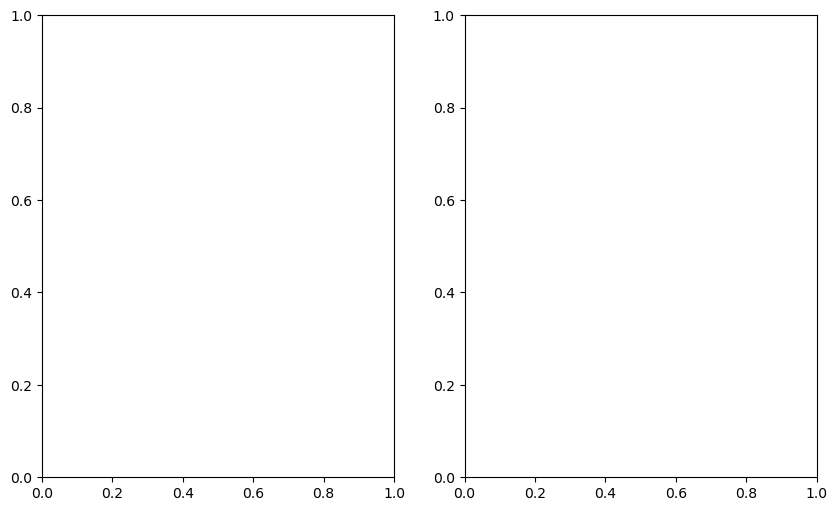

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
mag_range = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][mag_range], dat_0['cl'][mag_range], 'o', ms=1, label='SEx')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('F105W mag')
ax[0].set_ylabel('Stellarity')
ax[0].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[0].axhline(0.8, 0, 1, color='red', ls='--', lw=1)


ax[1].plot(dat_1['mag_isocor'][mag_range], dat_1['cl'][mag_range], 'o', ms=1, label='SEX')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('F160W mag')
ax[1].set_ylabel('Stellarity')
ax[1].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[1].axhline(0.8, 0, 1, color='red', ls='--', lw=1)

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)

### 3) CMDs of galaxies

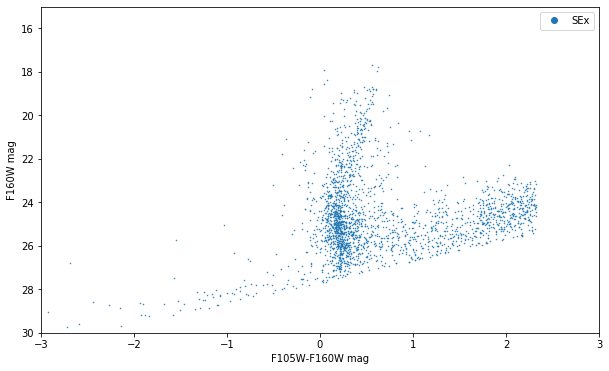

In [230]:
# gal_cnd = ((dat_V['mag_isocor'] < 30.0) & (dat_V['magerr_isocor'] < 1) & (dat_I['mag_isocor'] < 30.0) & (dat_I['magerr_isocor'] < 1) & \
#           (dat_V['flxrad'] > 4.) & (dat_V['fwhm'] > 4.) & (dat_I['flxrad'] > 4.) & (dat_I['fwhm'] > 4.) & \
#           (dat_V['mag_isocor']-dat_I['mag_isocor'] > -5.0) & (dat_V['mag_isocor']-dat_I['mag_isocor'] < 5.0) & \
#           (dat_I['cl'] < 0.4)) 

fig, ax = plt.subplots(1, 1, figsize=(10,6))
galcnd = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)&(dat_0['flag']<4) #&(dat_0['flxrad'] > 4.) & (dat_0['fwhm'] > 4.) & (dat_1['fwhm'] > 4.) & (dat_1['merr'] < 0.5) & (dat_0['merr'] < 0.5)&(dat_1['cl'] < 0.4)


# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax.plot(dat_0['mag_isocor'][galcnd]-dat_1['mag_isocor'][galcnd], dat_1['mag_isocor'][galcnd], 'o', ms=0.5, label='SEx')
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
ax.set_xlabel('F105W-F160W mag')
ax.set_ylabel('F160W mag')

#=================================================================
lgnd0 = ax.legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
